# Benchmark performance

Let's look at the performance of some other models to put in context how well/poorly our model performs.

Import all libraries used.

In [34]:
import os
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import rnn_utils

Set plot style for <code>matplotlib</code>.

In [33]:
plt.style.use('fivethirtyeight')

In [2]:
# Load weather stations
weather_stations = [
    pd.read_csv('../data/weather/processed/' + file, parse_dates=['UTC_DATE'], index_col='UTC_DATE')
    .drop(columns=['Unnamed: 0', 'WIND_SPEED', 'WIND_DIRECTION', 'VAPOR_PRESSURE', 'x', 'y', 'STATION_NAME'])
    for file in os.listdir('../data/weather/processed')
]

# Get list of station names
station_names = [file[:-4] for file in os.listdir('../data/weather/processed')]

# Load radar images (loading as mmap to save RAM)
images_array = np.load('../data/radar/processed/all_images.npy', mmap_mode='r')[24510:]

weather_images = pd.read_csv('../data/radar/processed/image_dates.csv', parse_dates=['UTC_DATE']).iloc[24510:].reset_index(drop=True)

for i, weather_station in enumerate(weather_stations):
    weather_stations[i] = weather_station.loc[weather_station.index.isin(weather_images['UTC_DATE'])]

In [3]:
weather_data = pd.DataFrame()

# Create single master dataframe
for i, df in enumerate(weather_stations):
    
    df = df.copy()
    
    # Scale RH and pressure
    df['RELATIVE_HUMIDITY'] = df['RELATIVE_HUMIDITY'] / 100
    df['STATION_PRESSURE'] = df['STATION_PRESSURE'] / 101.325
    
    for column in df.columns:
        if column != 'UTC_DATE':  # Avoid renaming the UTC_DATE column
            df.rename(columns={column: f'{column}_{station_names[i]}'}, inplace=True)
    
    if weather_data.empty:
        weather_data = df
    else:
        weather_data = pd.merge(weather_data, df, on='UTC_DATE', how='left')

weather_data = weather_data.sort_values(by='UTC_DATE')
weather_data.head()

,PRECIP_AMOUNT_BARRIE-ORO,TEMP_BARRIE-ORO,DEW_POINT_TEMP_BARRIE-ORO,RELATIVE_HUMIDITY_BARRIE-ORO,STATION_PRESSURE_BARRIE-ORO,WIND_X_BARRIE-ORO,WIND_Y_BARRIE-ORO,PRECIP_AMOUNT_EGBERT CS,TEMP_EGBERT CS,DEW_POINT_TEMP_EGBERT CS,...,STATION_PRESSURE_TORONTO CITY CENTRE,WIND_X_TORONTO CITY CENTRE,WIND_Y_TORONTO CITY CENTRE,PRECIP_AMOUNT_TORONTO CITY,TEMP_TORONTO CITY,DEW_POINT_TEMP_TORONTO CITY,RELATIVE_HUMIDITY_TORONTO CITY,STATION_PRESSURE_TORONTO CITY,WIND_X_TORONTO CITY,WIND_Y_TORONTO CITY
UTC_DATE,,,,,,,,,,,,,,,,,,,,,
2014-11-05 20:00:00,0.0,6.2,-0.8,0.61,0.970047,-17.726540,-3.125667,0.0,7.0,-1.5,...,0.996003,-22.552623,-8.208483e+00,0.0,9.8,0.8,0.53,0.991463,-22.534875,-8.167757
2014-11-05 21:00:00,0.0,5.9,-0.3,0.64,0.970146,-12.802501,-2.257426,0.0,6.6,-0.9,...,0.996003,-12.802501,2.257426e+00,0.0,9.6,0.8,0.54,0.991463,-12.792396,2.267109
2014-11-05 22:00:00,0.0,5.5,0.0,0.68,0.970540,-8.863270,-1.562834,0.0,6.3,0.1,...,0.996496,-21.000000,-3.857637e-15,0.0,9.3,1.3,0.57,0.991957,-20.946363,-0.002198
2014-11-05 23:00:00,0.0,5.4,0.4,0.70,0.971034,-5.638156,-2.052121,0.0,6.2,0.5,...,0.996891,-15.974775,5.814342e+00,0.0,9.2,1.3,0.58,0.992351,-15.942379,5.787378
2014-11-06 00:00:00,0.0,5.0,0.9,0.75,0.971330,-4.330127,-2.500000,0.0,6.0,0.5,...,0.997089,-10.336619,3.762222e+00,0.0,8.2,1.2,0.61,0.992647,-10.309870,3.732272


In [4]:
weather_data = weather_data.reset_index()
weather_data.index

RangeIndex(start=0, stop=71238, step=1)

In [5]:
print('VALIDATION CHUNKS:')
chunks = rnn_utils.split_year_into_chunks(2022)
print(chunks)

VALIDATION CHUNKS:
[[datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2022, 2, 15, 15, 0)], [datetime.datetime(2022, 2, 15, 15, 0), datetime.datetime(2022, 4, 2, 6, 0)], [datetime.datetime(2022, 4, 2, 6, 0), datetime.datetime(2022, 5, 17, 21, 0)], [datetime.datetime(2022, 5, 17, 21, 0), datetime.datetime(2022, 7, 2, 12, 0)], [datetime.datetime(2022, 7, 2, 12, 0), datetime.datetime(2022, 8, 17, 3, 0)], [datetime.datetime(2022, 8, 17, 3, 0), datetime.datetime(2022, 10, 1, 18, 0)], [datetime.datetime(2022, 10, 1, 18, 0), datetime.datetime(2022, 11, 16, 9, 0)], [datetime.datetime(2022, 11, 16, 9, 0), datetime.datetime(2022, 12, 31, 23, 59, 59)]]


In [6]:
# Resetting the dataframes
train_data = pd.DataFrame()
validation_data = pd.DataFrame()
test_data = pd.DataFrame(weather_data[weather_data['UTC_DATE'] >= datetime(2023, 1, 1)])

for i, (start_date, end_date) in enumerate(chunks):
    year = 2015 + i
    start_date = start_date.replace(year=year)
    end_date = end_date.replace(year=year)
    
    b = (weather_data['UTC_DATE'] >= start_date) & (weather_data['UTC_DATE'] < end_date)
    val =  pd.DataFrame(weather_data[b])
    train = pd.DataFrame(weather_data[~b & (weather_data['UTC_DATE'].dt.year == year)])
    
    # Append to overall train set
    train_data = pd.concat([train_data, train])
    # Append to overall val set
    validation_data = pd.concat([validation_data, val])

# Display sizes of each dataset
len(train_data), len(validation_data), len(test_data)

(60053, 8743, 1094)

## Make predictions on test set

Let's visualize precipitation test data.

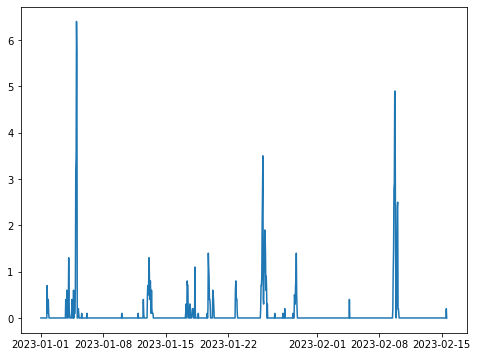

In [7]:
plt.figure(figsize=(8, 6))
test_dates = test_data['UTC_DATE'].tolist()
test_precip = test_data['PRECIP_AMOUNT_TORONTO CITY'].to_numpy()
plt.plot(test_dates, test_precip)

## Predict with average model

In [8]:
n = 0
running_loss = 0

# Iterate over all test dates, check if the sequence is consecutive,
# make a prediction, then calculate the loss.
for i in range(len(test_dates) - 8):
    window = test_dates[i:i + 8]
    precip = test_precip[i:i+ 8]
    
    train_precip = precip[:6]
    target_precip = precip[6:]

    if window[0] + timedelta(hours=7) == window[-1]:
        # Consecutive
        pred = np.mean(train_precip)
        pred = np.repeat(pred, 2)
        
        running_loss += np.sum((pred - target_precip) ** 2)
        n += 1

print('MSE (Naive average):', running_loss / n)

MSE (Naive average): 0.4069766728054021


## Predict with persistence model

In [9]:
n = 0
running_loss = 0

# Iterate over all test dates, check if the sequence is consecutive,
# make a prediction, then calculate the loss.
for i in range(len(test_dates) - 8):
    window = test_dates[i:i + 8]
    precip = test_precip[i:i+ 8]
    
    train_precip = precip[:6]
    target_precip = precip[6:]

    if window[0] + timedelta(hours=7) == window[-1]:
        # Consecutive
        pred = train_precip[-1]
        pred = np.repeat(pred, 2)
        
        running_loss += np.sum((pred - target_precip) ** 2)
        n += 1

print('MSE (Naive persistence):', running_loss / n)

MSE (Naive persistence): 0.304585635359116


## Predict with Random Forest Model

In [10]:
rf_train_data = train_data.drop(columns=['UTC_DATE'])

# Let's only select features from TORONTO_CITY for the random forest
rf_train_data = rf_train_data[[
    'PRECIP_AMOUNT_TORONTO CITY',
    'TEMP_TORONTO CITY',
    'DEW_POINT_TEMP_TORONTO CITY',
    'RELATIVE_HUMIDITY_TORONTO CITY',
    'STATION_PRESSURE_TORONTO CITY'   
]].values
rf_train_data

array([[  0.        , -23.8       , -30.6       ,   0.53      ,
          1.00044412],
       [  0.        , -22.8       , -29.7       ,   0.53      ,
          1.00093758],
       [  0.        , -21.4       , -28.6       ,   0.52      ,
          1.00113496],
       ...,
       [  4.7       ,  -0.4       ,  -1.6       ,   0.92      ,
          0.98998273],
       [  3.9       ,  -0.7       ,  -1.8       ,   0.92      ,
          0.98899581],
       [  2.6       ,  -0.8       ,  -2.1       ,   0.91      ,
          0.98860104]])

In [11]:
train_dates = train_data['UTC_DATE'].tolist()
train_precip = train_data['PRECIP_AMOUNT_TORONTO CITY'].to_numpy()

In [17]:
inputs = []
outputs = []

# Create windows
for i in range(len(train_dates) - 8):
    window = train_dates[i:i + 8]
    precip = train_precip[i:i + 8]

    if window[0] + timedelta(hours=7) == window[-1]:
        # Consecutive
        inputs.append(rf_train_data[i:i + 6, :].flatten())
        outputs.append(precip[6:])

train_inputs = np.array(inputs)
train_outputs = np.array(outputs)
print(train_inputs.shape, train_outputs.shape)

(58318, 30) (58318, 2)


In [32]:
# Create random forest regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=40, n_jobs=-1)
rf_regressor.fit(train_inputs, train_outputs)

RandomForestRegressor(max_depth=40, n_jobs=-1, random_state=42)

In [29]:
inputs = []
outputs = []

rf_test_data = test_data.drop(columns=['UTC_DATE'])
rf_test_data = rf_test_data[[
    'PRECIP_AMOUNT_TORONTO CITY',
    'TEMP_TORONTO CITY',
    'DEW_POINT_TEMP_TORONTO CITY',
    'RELATIVE_HUMIDITY_TORONTO CITY',
    'STATION_PRESSURE_TORONTO CITY'   
]].values

# Create windows
for i in range(len(test_dates) - 8):
    window = test_dates[i:i + 8]
    precip = test_precip[i:i + 8]

    if window[0] + timedelta(hours=7) == window[-1]:
        # Consecutive
        inputs.append(rf_test_data[i:i + 6, :].flatten())
        outputs.append(precip[6:])

test_inputs = np.array(inputs)
test_outputs = np.array(outputs)
print(test_inputs.shape, test_outputs.shape)

(1086, 30) (1086, 2)


In [30]:
# Make predictions with random forest model and calculate loss
pred = rf_regressor.predict(test_inputs).flatten()
true = test_outputs.flatten()

loss = np.mean((pred - true) ** 2)
print('MSE (Basic RF):', loss)

MSE (Basic RF): 0.15493580540369475


## Predict with XGBoost Model

In [20]:
# Creating and fitting the XGBoost regressor model
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror', 
    learning_rate=0.01,  # Adjust learning rate
    n_estimators=800,   # Number of trees (estimators)
    max_depth=4,        # Maximum depth of a tree
    subsample=0.8,      # Subsample ratio of the training instance
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42,
    gamma=1,
    n_jobs=-1
)
xgb_regressor.fit(train_inputs, train_outputs)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [31]:
# Make predictions with XGBoost model and calculate loss
pred = xgb_regressor.predict(test_inputs).flatten()
true = test_outputs.flatten()

loss = np.mean((pred - true) ** 2)
print('MSE (XGBoost):', loss)

MSE (XGBoost): 0.11346626318842216
